In [1]:
import pandas as pd 
import numpy as np
import funciones as fs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler


PROCEDEMOS A GENERAR EL DATAFRAME PARA EMPEZAR CON LA LIMPIEZA. 

In [18]:
df = pd.read_csv("bank-full.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


ANALIZAMOS LA COMPOSICIÓN DE LOS DATOS

In [19]:
fs.dataset_overview(df)

Shape
Rows: 45211 | Columns: 17
Data Types
object    10
int64      7
Name: count, dtype: int64
Missing Values
No missing values


In [20]:
fs.col_numericas(df)


,count,mean,std,min,25%,50%,75%,max,skew
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0,0.684818
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0,8.360308
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0,0.093079
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0,3.144318
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0,4.898650
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0,2.615715
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0,41.846454


DE ACUERDO A LOS COMENTARIOS DEL DATASET, PROCEDEREMOS A ELIMINAR LAS COLUMNAS "DURATION" Y "DAY" YA QUE NO NOS SERVIRA PARA DESARROLLAR UN MODELO PREDICTIVO. 

In [21]:
columns_drop = ["duration", "day"]

In [22]:
fs.drop_columns(df, columns_drop)

VAMOS CREAR UNA NUEVA COLUMNA PARA DIVIDIR LOS MESES EN CUATRIMESTRES.

In [23]:
df["month"].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [24]:
def month_to_quarter(month):
    if month in ['jan','feb','mar']:
        return 'Q1'
    elif month in ['apr','may','jun']:
        return 'Q2'
    elif month in ['jul','aug','sep']:
        return 'Q3'
    else:
        return 'Q4'

df['quarter'] = df['month'].apply(month_to_quarter)

In [25]:
df = df.drop('month', axis=1)

In [26]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,campaign,pdays,previous,poutcome,y,quarter
0,58,management,married,tertiary,no,2143,yes,no,unknown,1,-1,0,unknown,no,Q2
1,44,technician,single,secondary,no,29,yes,no,unknown,1,-1,0,unknown,no,Q2
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,1,-1,0,unknown,no,Q2
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,1,-1,0,unknown,no,Q2
4,33,unknown,single,unknown,no,1,no,no,unknown,1,-1,0,unknown,no,Q2


CREAMOS UNA LISTA DE LAS COLUMNAS NUMERICAS

In [27]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [8]:
fs.col_categoricas(df)

,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959
y,45211,2,no,39922


CREAMOS UNA LISTA DE LAS COLUMNAS CATEGORICAS

In [28]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('y')

PROCEDEMOS A VERIFICAR LA PROPORCIÓN DE LA COLUMNA "Y" PARA EVALUAR EL ESCENARIO.

In [29]:
df["y"].value_counts(normalize=True)

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

<Axes: xlabel='y'>

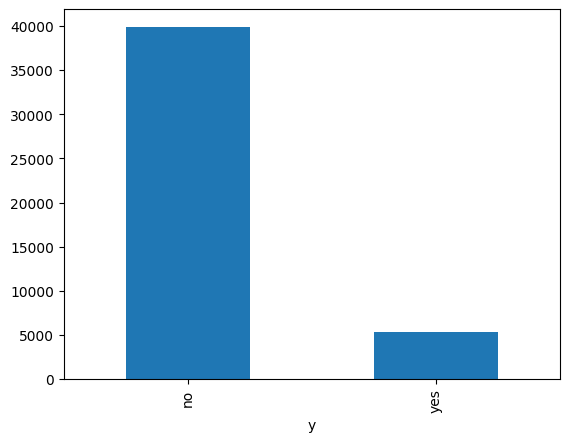

In [30]:
df['y'].value_counts().plot(kind='bar')

VERIFICAMOS QUE HAY UN DESBALANCE SIGNIFICATIVO DE LOS "NO" LO CUAL NOS HARA TOMAR ATENCION A LAS METRICIAS SELECCIONADAS A LA HORA DE REALIZAR EL MODELO PREDICTIVO. 

UNA VEZ QUE TENEMOS LA INFORMACIÓN GENERAL DEL DATASET AVANZAMOS EN NUESTRO ANALISIS. LO PRIMERO QUE HAREMOS ES VER LA RELACION ENTRE CLIENTES QUE DAN EL "SI" PARA ABRIR UN DEPOSITO Y LAS COLUMNAS NUMERICAS.

In [31]:
df.groupby("y")[numerical_columns].mean()

,age,balance,campaign,pdays,previous
y,,,,,
no,40.838986,1303.714969,2.846350,36.421372,0.502154
yes,41.670070,1804.267915,2.141047,68.702968,1.170354


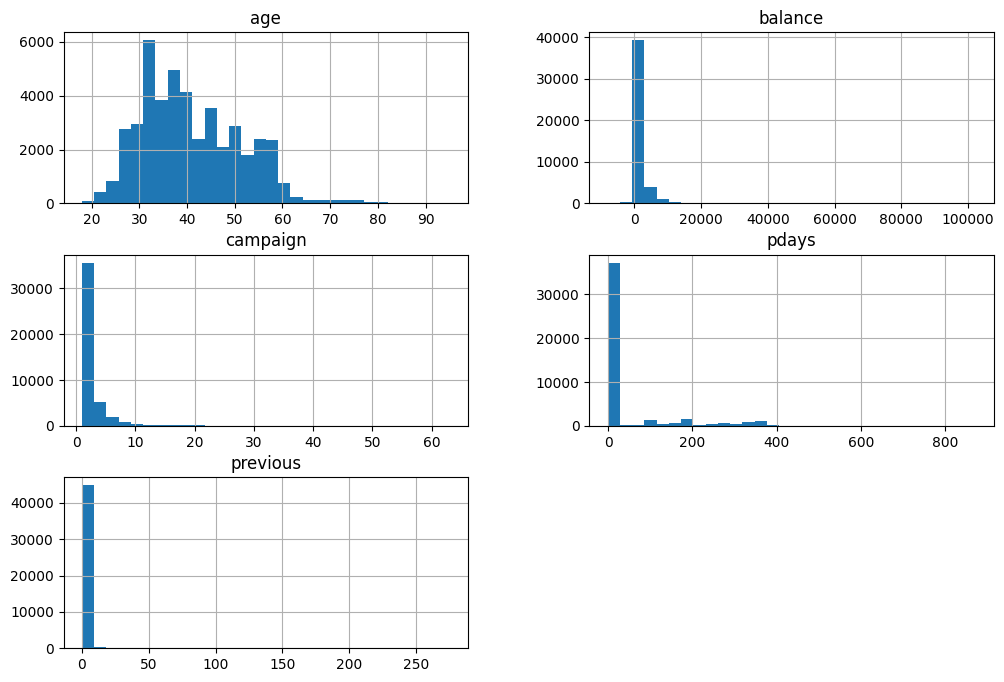

In [32]:
df[numerical_columns].hist(figsize=(12,8), bins=30)
plt.show()

De estos histogramas podemos sacar las siguientes observaciones: 
 - El balance tiene una clara acumulación entre los 1k y 25k pero con outliers que hacen mover a la media hacia un valor mas alto. 
 - La mayoria de los clientes, segun "campaign", tienen entre 3 y 5 llamadas. 
 - Hay una cola extendida en el grafico pdays lo que sugiere que se los llama dentro de un año calendario a cada cliente. 
 - Por lo menos se llamo una vez al cliente antes de esta campaña de marketing. 

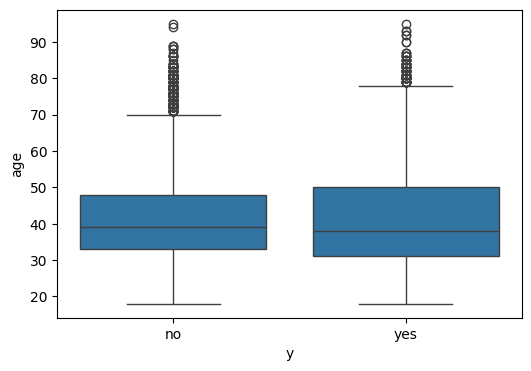

In [33]:
plt.figure(figsize=(6,4))
sns.boxplot(x='y', y='age', data=df)
plt.show()

LA MEDIA DE EDAD DE LOS CLIENTES SI Y NO ES PRACTICAMENTE IGUAL PERO EL "NO" TIENE MUCHOS MAS OUTLIERS. 

PARA FINALIZAR CON EL EDA Y SEGUIR AVANZANDO EN EL MODELO PROCEDEREMOS A CAMBIAR EL FORMATO DE LA COLUMNA "y".

In [34]:
df['y'] = df['y'].map({'no':0, 'yes':1})
df["y"]

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

HAREMOS UNA PRUEBA DE KNN CON LOS VALORES NUMERICOS TAL COMO LOS TENEMOS PARA VER SU RESULTADO Y A PARTIR DE ALLI EMPEZAR A TRABAJAR EL MODELO.

SEPARAMOS LAS COLUMNAS FEATURES DE TARGET ("y")

In [35]:
features = df.select_dtypes(include=['int64', 'float64'])
target = df["y"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0, stratify=target)

In [37]:
X_train.head()

,age,balance,campaign,pdays,previous,y
32213,35,1350,1,330,1,0
36907,59,145,2,287,13,1
1447,53,1786,2,-1,0,0
10973,37,1170,3,-1,0,0
26982,46,829,7,-1,0,0


In [38]:
y_train.head()

32213    0
36907    1
1447     0
10973    0
26982    0
Name: y, dtype: int64

In [39]:
knn = KNeighborsClassifier(n_neighbors=5)

In [40]:
knn

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [41]:
knn.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [42]:
pred = knn.predict(X_test)
pred

array([0, 0, 0, ..., 1, 0, 0], shape=(9043,))

In [43]:
y_test.values

array([0, 0, 0, ..., 1, 0, 1], shape=(9043,))

In [44]:
knn.score(X_test, y_test) 

0.8781377861329205

LA ACCURACY ES DE 0,88 LO CUAL NOS DICE QUE EL MODELO (SOLO CONTEMPLANDO LAS VARIABLES NUMERICAS) TIENE UN GRAN PORCENTAJE DE EFECTIVIDAD. TENIENDO EN CUENTA QUE EL 88% DE LA COLUMNA "y" ES NO, SEGURAMENTE REPLIQUE ELLO Y HACE QUE EL MODELO DE ESTE PORCENTAJE DE ACCURACY. PROBEMOS CON OTROS TESTS:

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# accuracy
print(accuracy_score(y_test, pred))

# precision
print(precision_score(y_test, pred, average='macro'))

# recall
print(recall_score(y_test, pred, average='macro'))

# F1-score
print(f1_score(y_test, pred, average='macro'))

0.8781377861329205
0.6601479278661024
0.5497212992697792
0.5613174739345071


AQUI PODEMOS OBSERVAR COMO A PARTIR DE LOS TEST DE PRECISION, RECALL Y F1 TIENEN UN RESULTADO BASTANTE MAS BAJO LO QUE NOS SUGIERE QUE HABRA QUE ANALIZAR TODAS LAS VARIABLES DEL DF PARA QUE LE MODELO SEA EFICIENTE EN SU TOTALIDAD. 

AVAZAREMOS EN LA MEJORA DEL MODELO REALIZANDO UN BALANCEO, PARA ELLO LO PRIMERO QUE HACEMOS ES PASAR TODAS LAS COLUMNAS CATEGORICAS A NUMERICAS.

In [50]:
columns_to_encode = df.select_dtypes(include="object").columns
df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype = int)
print(df_encoded.columns)

Index(['age', 'balance', 'campaign', 'pdays', 'previous', 'y', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'quarter_Q1',
       'quarter_Q2', 'quarter_Q3', 'quarter_Q4'],
      dtype='object')


In [52]:
features = df_encoded.drop('y', axis=1)
target = df_encoded["y"]

In [53]:
features.head()

,age,balance,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4
0,58,2143,1,-1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,1,0,0
1,44,29,1,-1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
2,33,2,1,-1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
3,47,1506,1,-1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
4,33,1,1,-1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


In [54]:
target.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

In [55]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0, stratify=target)

In [56]:
normalizer = MinMaxScaler()

In [57]:
normalizer.fit(X_train)

,"feature_range feature_range: tuple (min, max), default=(0, 1)Desired range of transformed data.","(0, ...)"
,"copy copy: bool, default=TrueSet to False to perform inplace row normalization and avoid acopy (if the input is already a numpy array).",True
,"clip clip: bool, default=FalseSet to True to clip transformed values of held-out data toprovided `feature_range`.Since this parameter will clip values, `inverse_transform` may notbe able to restore the original data... note:: Setting `clip=True` does not prevent feature drift (a distribution shift between training and test data). The transformed values are clipped to the `feature_range`, which helps avoid unintended behavior in models sensitive to out-of-range inputs (e.g. linear models). Use with care, as clipping can distort the distribution of test data... versionadded:: 0.24",False


In [58]:
X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)

In [59]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_norm, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [60]:
pred = knn.predict(X_test_norm)
pred

array([0, 0, 0, ..., 0, 0, 0], shape=(9043,))

In [61]:
y_test.values

array([0, 0, 0, ..., 1, 0, 1], shape=(9043,))

In [62]:
knn.score(X_test_norm, y_test) 

0.8865420767444432

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# accuracy
print(accuracy_score(y_test, pred))

# precision
print(precision_score(y_test, pred, average='macro'))

# recall
print(recall_score(y_test, pred, average='macro'))

# F1-score
print(f1_score(y_test, pred, average='macro'))

0.8865420767444432
0.7208941516348495
0.5938375711548
0.6210861449162479


In [71]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.54      0.21      0.30      1058

    accuracy                           0.89      9043
   macro avg       0.72      0.59      0.62      9043
weighted avg       0.86      0.89      0.86      9043



HABIENDO HECHO EL BALANCEO DE LA MODELO PODEMOS OBSERVAR QUE LOS RESULTADOS SON MEJORES PERO SIGUE HABIENDO MUCHA INFORMACIÓN PARA OBTENER ACCURACY. PROCEDEREMOS A ANALIZAR LAS COLUMNAS DEL DF ORIGINAL PARA QUEDARNOS SOLO CON AQUELLAS QUE NOS PERMITAN DESARROLLAR UN MODELO MAS EFECTIVO. 

In [64]:
df_encoded.head()

,age,balance,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4
0,58,2143,1,-1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
1,44,29,1,-1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
2,33,2,1,-1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
3,47,1506,1,-1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
4,33,1,1,-1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0


PRIMERO VEREMOS LA VARIANZA DEL DATASET:

In [65]:
df_encoded.var().sort_values().head(10)

job_unknown          0.006330
default_no           0.017702
default_yes          0.017702
job_student          0.020317
job_housemaid        0.026675
job_unemployed       0.027990
job_entrepreneur     0.031809
poutcome_success     0.032305
job_self-employed    0.033706
poutcome_other       0.039043
dtype: float64

SEGUNDO VEREMOS LA CORRELACION DE LA COLUMNA "y" CON LAS DEMAS: primero las que tienen mayor correlación y luego las que menos tienen. 

In [66]:
df_encoded.corr()['y'].sort_values(ascending=False).head(10)

y                   1.000000
poutcome_success    0.306788
housing_no          0.139173
contact_cellular    0.135873
pdays               0.103621
previous            0.093236
job_retired         0.079245
job_student         0.076897
quarter_Q1          0.069035
loan_no             0.068185
Name: y, dtype: float64

In [67]:
df_encoded.corr()['y'].sort_values().head(10)

poutcome_unknown      -0.167051
contact_unknown       -0.150935
housing_yes           -0.139173
campaign              -0.073172
quarter_Q2            -0.073002
job_blue-collar       -0.072083
loan_yes              -0.068185
marital_married       -0.060260
education_primary     -0.040393
education_secondary   -0.036388
Name: y, dtype: float64

TENIENDO AMBAS RELACIONES, PROCEDEMOS A GRAFICARLO PARA QUE SEA MAS VISUAL.

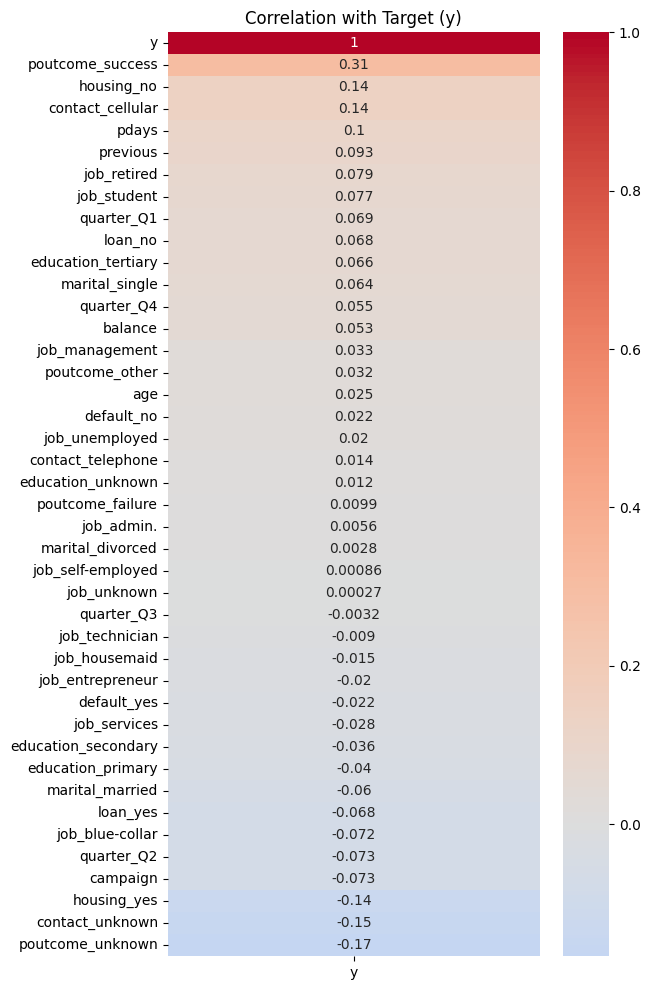

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_encoded.corr()[['y']].sort_values(by='y', ascending=False)

plt.figure(figsize=(6,12))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation with Target (y)")
plt.show()

TENIENDO EN CUENTA LA CANTIDAD DE COLUMNAS QUE SE HAN GENERADO Y LA POCA CORRELACION QUE HAY, ELIMINAREMOS DEL DF ORIGINAL PARA LUEGO VOLVER A REALIZAR EL DUMMIES. 

In [69]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,campaign,pdays,previous,poutcome,y,quarter
0,58,management,married,tertiary,no,2143,yes,no,unknown,1,-1,0,unknown,0,Q2
1,44,technician,single,secondary,no,29,yes,no,unknown,1,-1,0,unknown,0,Q2
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,1,-1,0,unknown,0,Q2
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,1,-1,0,unknown,0,Q2
4,33,unknown,single,unknown,no,1,no,no,unknown,1,-1,0,unknown,0,Q2


In [70]:
df["job"].value_counts()

job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64